In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, concatenate, Dropout, Input, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt

# Load the datasets
img_dir = r'/kaggle/input/ussimandsegm/abdominal_US/abdominal_US/AUS/images/train'
mask_dir = r'/kaggle/input/ussimandsegm/abdominal_US/abdominal_US/AUS/annotations/train'

# Load and preprocess the training images
img_names = os.listdir(img_dir)
imgs = [Image.open(os.path.join(img_dir, img_name)) for img_name in img_names]
X = np.array([np.array(img.resize((464, 464))) for img in imgs])
X = X / 255.0  # Normalize the images to [0, 1] range

# Define a mapping from RGB values to class labels
colors_to_labels = {
    (255, 255, 0): 0,  # Yellow
    (255, 0, 255): 1,  # Red
    (100, 0, 100): 2,  # Darker red
    (0, 255, 0): 3  # Green
}

# Load, preprocess, and encode the masks
mask_names = os.listdir(mask_dir)
masks = [Image.open(os.path.join(mask_dir, mask_name)) for mask_name in mask_names]
masks = [mask.resize((464, 464)) for mask in masks] 
Y = np.empty((len(masks), 464, 464, len(colors_to_labels)))

for i, mask in enumerate(masks):
    mask_array = np.array(mask)
    for j, (color, label) in enumerate(colors_to_labels.items()):
        Y[i, :, :, j] = np.all(mask_array == np.array(color).reshape(1, 1, 3), axis=2)

# Split the data into a training set and a validation set
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)


In [6]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Cropping2D, concatenate, Dropout, Input, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt

# Load the datasets
img_dir = r'/kaggle/input/ussimandsegm/abdominal_US/abdominal_US/AUS/images/train'
mask_dir = r'/kaggle/input/ussimandsegm/abdominal_US/abdominal_US/AUS/annotations/train'

# Load and preprocess the training images
img_names = os.listdir(img_dir)
imgs = [Image.open(os.path.join(img_dir, img_name)) for img_name in img_names]
X = np.array([np.array(img.resize((464, 464))) for img in imgs])
X = X / 255.0  # Normalize the images to [0, 1] range

# Define a mapping from RGB values to class labels
colors_to_labels = {
    (255, 255, 0): 0,  # Yellow
    (255, 0, 255): 1,  # Red
    (100, 0, 100): 2,  # Darker red
    (0, 255, 0): 3  # Green
}

# Load, preprocess, and encode the masks
mask_names = os.listdir(mask_dir)
masks = [Image.open(os.path.join(mask_dir, mask_name)) for mask_name in mask_names]
masks = [mask.resize((464, 464)) for mask in masks] 
Y = np.empty((len(masks), 464, 464, len(colors_to_labels)))

for i, mask in enumerate(masks):
    mask_array = np.array(mask)
    for j, (color, label) in enumerate(colors_to_labels.items()):
        Y[i, :, :, j] = np.all(mask_array == np.array(color).reshape(1, 1, 3), axis=2)

# Split the data into a training set and a validation set
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# Custom upsample block
def upsample_block(n_filters, inputs):
    x = UpSampling2D((2, 2))(inputs)
    x = Conv2D(n_filters, 3, padding='same')(x)
    return x

def conv_block(n_filters, inputs):
    x = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(inputs)
    x = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(x)
    return x

def unet_resnet_model(input_size=(464, 464, 3), n_classes=4):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_size)
    base_model.trainable = False
    
    block1 = base_model.get_layer("conv1_relu").output
    block2 = base_model.get_layer("conv2_block3_out").output
    block3 = base_model.get_layer("conv3_block4_out").output
    block4 = base_model.get_layer("conv4_block6_out").output
    block5 = base_model.get_layer("conv5_block3_out").output

    x = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(block5)
    x = Cropping2D(cropping=((1, 0), (1, 0)))(x)  # Adjusting size to match block4
    x = concatenate([x, block4])
    x = conv_block(512, x)

    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = concatenate([x, block3])
    x = conv_block(256, x)

    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    x = concatenate([x, block2])
    x = conv_block(128, x)

    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = concatenate([x, block1])
    x = conv_block(64, x)

    x = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(x)
    x = conv_block(32, x)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=outputs)
    
    return model


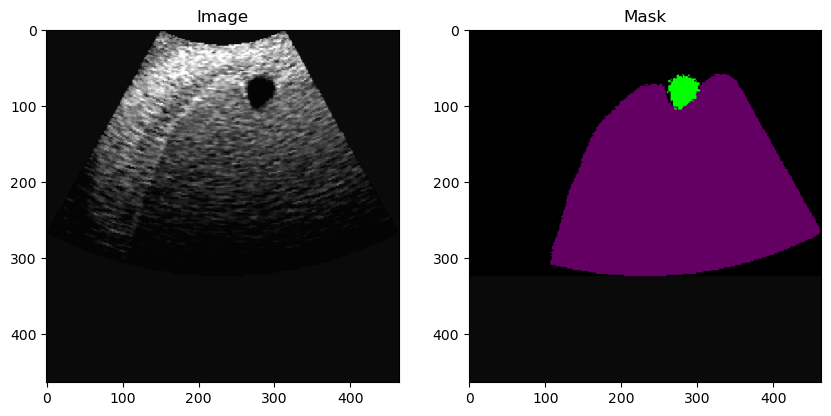

In [7]:
import matplotlib.pyplot as plt
import tensorflow as tf
# import the necessary libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Dropout, Conv2DTranspose, Lambda
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt


# Load and preprocess the trai
image_list = [os.path.join(img_dir, img_name) for img_name in os.listdir(img_dir)]
mask_list = [os.path.join(mask_dir, mask_name) for mask_name in os.listdir(mask_dir)]

image_list_ds = tf.data.Dataset.from_tensor_slices(image_list)
mask_list_ds = tf.data.Dataset.from_tensor_slices(mask_list)

# Ensure the lists are in the same order
image_list_ds = tf.data.Dataset.from_tensor_slices(image_list)
mask_list_ds = tf.data.Dataset.from_tensor_slices(mask_list)

# Create a Dataset of (image, mask) pairs
dataset = tf.data.Dataset.zip((image_list_ds, mask_list_ds))

def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (464, 464), method='nearest')
    input_mask = tf.image.resize(mask, (464, 464), method='nearest')

    return input_image, input_mask

dataset = dataset.map(process_path)
dataset = dataset.map(preprocess)

# Verify the preprocessing
for image, mask in dataset.take(1):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Image')
    plt.subplot(1, 2, 2)
    plt.imshow(mask)
    plt.title('Mask')
    plt.show()

In [ ]:
# Instantiate the model
model = unet_resnet_model()

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy')

# Train the model
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_val, Y_val), verbose=1)

# Evaluate the model's performance on the validation set
val_loss = model.evaluate(X_val, Y_val, verbose=1)
print("Validation loss: ", val_loss)

# Plot the training history
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Predict the masks on the validation set
preds_val = model.predict(X_val, verbose=1)

# Threshold predictions
preds_val_t = (preds_val > 0.5).astype(np.uint8)

# Plot some predicted masks along with their ground truth masks
plt.figure(figsize=(20, 10))

for i in range(5):
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(np.argmax(Y_val[i], axis=-1), cmap='gray')
    plt.title('Ground Truth')

    plt.subplot(5, 2, 2*i+2)
    plt.imshow(np.argmax(preds_val_t[i], axis=-1), cmap='gray')
    plt.title('Predicted')

94765736/94765736 [==============================] - 0s 0us/step
Epoch 1/20
16/16 [==============================] - 1817s 114s/step - loss: 0.1898 - val_loss: 0.1959
Epoch 2/20
